## Group No : 43

## Group Member Names:
1. LAKSHMISRINIVAS PERAKAM
2. SHAILESH KUMAR SINGH
3. SUBHRANSU MISHRA
4. JAWAHARLAL RAJAN S


1.**Problem statement**: 

* Develop a reinforcement learning agent using dynamic programming to solve the Treasure Hunt problem in a FrozenLake environment. The agent must learn the optimal policy for navigating the lake while avoiding holes and maximizing its treasure collection.

2.**Scenario**:
* A treasure hunter is navigating a slippery 5x5 FrozenLake grid. The objective is to navigate through the lake collecting treasures while avoiding holes and ultimately reaching the exit (goal).
Grid positions on a 5x5 map with tiles labeled as S, F, H, G, T. The state includes the current position of the agent and whether treasures have been collected. 


#### Objective
* The agent must learn the optimal policy π* using dynamic programming to maximize its cumulative reward while navigating the lake.

#### About the environment

The environment consists of several types of tiles:
* Start (S): The initial position of the agent, safe to step.
* Frozen Tiles (F): Frozen surface, safe to step.
* Hole (H): Falling into a hole ends the game immediately (die, end).
* Goal (G): Exit point; reaching here ends the game successfully (safe, end).
* Treasure Tiles (T): Added to the environment. Stepping on these tiles awards +5 reward but does not end the game. 

After stepping on a treasure tile, it becomes a frozen tile (F).
The agent earns rewards as follows:
* Reaching the goal (G): +10 reward.
* Falling into a hole (H): -10 reward.
* Collecting a treasure (T): +5 reward.
* Stepping on a frozen tile (F): 0 reward.

#### States
* Current position of the agent (row, column).
* A boolean flag (or equivalent) for whether each treasure has been collected.

#### Actions
* Four possible moves: up, down, left, right

#### Rewards
* Goal (G): +10.
* Treasure (T): +5 per treasure.
* Hole (H): -10.
* Frozen tiles (F): 0.

#### Environment
Modify the FrozenLake environment in OpenAI Gym to include treasures (T) at certain positions. Inherit the original FrozenLakeEnv and modify the reset and step methods accordingly.
Example grid:

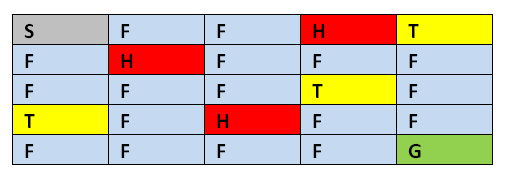


**Expected Outcomes:**
1.	Create the custom environment by modifying the existing “FrozenLakeNotSlippery-v0” in OpenAI Gym and Implement the dynamic programming using value iteration and policy improvement to learn the optimal policy for the Treasure Hunt problem.
2.	Calculate the state-value function (V*) for each state on the map after learning the optimal policy.
3.	Compare the agent’s performance with and without treasures, discussing the trade-offs in reward maximization.
4.	Visualize the agent’s direction on the map using the learned policy.
5.	Calculate expected total reward over multiple episodes to evaluate performance.

### Import required libraries and Define the custom environment - 2 Marks

In [1]:
# Import necessary libraries
import numpy as np
import gym
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Custom environment to create the given grid and respective functions that are required for the problem

#Include functions to take an action, get reward, to check if episode is over

In [2]:
class FrozenLakeTreasureEnv(FrozenLakeEnv):
    """
    Custom FrozenLake environment with treasures (T).
    Inherits from OpenAI Gym's FrozenLakeEnv.
    """
    def __init__(self, desc=None, is_slippery=False):
        """
        Initializes the environment with a custom grid.
        
        Args:
        - desc: Custom description of the grid (list of strings).
        - is_slippery: If True, makes the environment slippery.
        """
        if desc is None:
            raise ValueError("A custom grid (desc) must be provided for the environment.")
        super().__init__(desc=desc, map_name=None, is_slippery=is_slippery)
        self.treasure_positions = [(0, 4), (2, 3), (3, 0)]  # Example treasure locations
        self.collected_treasures = set()  # To track collected treasures
    def reset(self):
        """
        Resets the environment to its initial state.
        Clears the list of collected treasures.
        
        Returns:
        - The initial state.
        """
        self.collected_treasures = set()  # Reset collected treasures
        return super().reset()

    def step(self, action):
        """
        Executes an action in the environment and returns the result.
        Adds +5 reward for collecting treasures.
        """
        # Call the parent class's step method
        result = super().step(action)
    
        # Unpack the returned values appropriately
        if len(result) == 5:
            next_state, reward, done, info, extra = result
            # If there's an extra value, you can ignore it or process it based on your needs
        elif len(result) == 4:
            next_state, reward, done, info = result
        elif len(result) == 3:
            next_state, reward, done = result
            info = {}  # Default to an empty dictionary if `info` is not returned
        else:
            raise ValueError(f"Unexpected number of return values from step: {len(result)}")
    
        # Calculate the current position of the agent
        row, col = self.s // self.ncol, self.s % self.ncol  # Convert state index to grid coordinates
    
        # Check if the agent has stepped on a treasure
        if (row, col) in self.treasure_positions and (row, col) not in self.collected_treasures:
            reward += 5  # Add reward for collecting a treasure
            self.collected_treasures.add((row, col))  # Mark treasure as collected
    
        # Check if the episode ends (goal or hole)
        if self.desc[row, col] in [b'G', b'H']:
            done = True
    
        return next_state, reward, done, info


    def is_episode_over(self):
        """
        Checks if the episode has ended.
        
        Returns:
        - True if the episode has ended, False otherwise.
        """
        row, col = self.s // self.ncol, self.s % self.ncol  # Current position
        return self.desc[row][col] in [b'G', b'H']  # End if at Goal or Hole

    def render_custom(self):
        """
        Renders the environment with additional info about collected treasures.
        """
        print("Environment Grid:")
        self.render()
        print(f"Collected Treasures: {len(self.collected_treasures)} / {len(self.treasure_positions)}")


### Value Iteration Algorithm - 1 Mark

In [3]:
def value_iteration(env, gamma=0.9, theta=1e-4):
    """
    Performs value iteration to compute the optimal value function (V*) and policy (π*).
    
    Parameters:
    - env: The environment (FrozenLakeTreasureEnv)
    - gamma: Discount factor
    - theta: Convergence threshold
    
    Returns:
    - V: Optimal value function for all states
    - policy: Optimal policy (actions for each state)
    """
    V = np.zeros(env.observation_space.n)  # Initialize value function
    policy = np.zeros(env.observation_space.n, dtype=int)  # Initialize policy

    while True:
        delta = 0  # Tracks the maximum change in the value function
        for s in range(env.observation_space.n):
            # Determine if the state is terminal
            row, col = s // env.ncol, s % env.ncol
            if env.desc[row, col] in [b'H', b'G']:  # Hole or Goal
                continue

            # Compute Q-values for all actions
            q_values = [
                sum(p * (r + gamma * V[s_]) for p, s_, r, done in env.P[s][a])
                for a in range(env.action_space.n)
            ]
            # Update the value function for state s
            new_value = max(q_values)
            delta = max(delta, abs(new_value - V[s]))
            V[s] = new_value
            # Update the policy to the action with the highest Q-value
            policy[s] = np.argmax(q_values)

        # Break if the value function has converged
        if delta < theta:
            break

    return V, policy


### Policy Improvement Function - 1 Mark

In [4]:
def policy_improvement(env, V, gamma=0.9):
    """
    Derives an improved policy based on the given value function (V).
    
    Parameters:
    - env: The environment (FrozenLakeTreasureEnv)
    - V: Current value function
    - gamma: Discount factor
    
    Returns:
    - policy: Improved policy
    """
    policy = np.zeros(env.observation_space.n, dtype=int)
    for s in range(env.observation_space.n):
        if s in env.terminal_states:  # Skip terminal states
            continue
        # Compute Q values for all actions
        q_values = [
            sum(p * (r + gamma * V[s_]) for p, s_, r, done in env.P[s][a]) 
            for a in range(env.action_space.n)
        ]
        policy[s] = np.argmax(q_values)  # Choose the best action
    return policy


### Print the Optimal Value Function

In [5]:
def print_value_function(V, env):
    """
    Displays the optimal value function in grid form.
    """
    grid = np.array(V).reshape(env.nrow, env.ncol)
    print("Optimal Value Function:")
    print(grid)

custom_desc = [
    "SFFHT",
    "FHFFF",
    "FFFTF",
    "TFHFF",
    "FFFFG"
]

# Assuming env is your environment and V is the optimal value function computed earlier
env = FrozenLakeTreasureEnv(desc=custom_desc, is_slippery=False)

# Compute the optimal value function and policy using value iteration
V, policy = value_iteration(env)

# Print the optimal value function
print_value_function(V, env)


Optimal Value Function:
[[0.4782969 0.531441  0.59049   0.        0.729    ]
 [0.531441  0.        0.6561    0.729     0.81     ]
 [0.59049   0.6561    0.729     0.81      0.9      ]
 [0.6561    0.729     0.        0.9       1.       ]
 [0.729     0.81      0.9       1.        0.       ]]


### Visualization of the learned optimal policy - 1 Mark

In [6]:
def visualize_policy(env, policy):
    """
    Visualizes the optimal policy as arrows on the grid.
    """
    action_symbols = ['↑', '↓', '←', '→']  # Corresponding to actions 0, 1, 2, 3
    grid = np.array(env.desc, dtype=str)
    policy_grid = grid.copy()

    for s in range(env.observation_space.n):
        row, col = s // env.ncol, s % env.ncol
        if grid[row, col] in ['H', 'G']:
            continue
        policy_grid[row, col] = action_symbols[policy[s]]

    print("Learned Optimal Policy:")
    for row in policy_grid:
        print(' '.join(row))

custom_desc = [
    "SFFHT",
    "FHFFF",
    "FFFTF",
    "TFHFF",
    "FFFFG"
]

# Updated environment initialization
env = FrozenLakeTreasureEnv(desc=custom_desc, is_slippery=False)

# Compute the optimal value function and policy using value iteration
V, policy = value_iteration(env)

# Visualize the learned optimal policy
visualize_policy(env, policy)

Learned Optimal Policy:
↓ ← ↓ H ↓
↓ H ↓ ↓ ↓
↓ ↓ ← ↓ ↓
↓ ↓ H ↓ ↓
← ← ← ← G


### Evaluate the policy - 1 Mark

In [7]:
def evaluate_policy(env, policy, num_episodes=100):
    """
    Evaluates the given policy by running it over multiple episodes.
    
    Parameters:
    - env: The environment
    - policy: The policy to evaluate
    - num_episodes: Number of episodes to run
    
    Returns:
    - mean_reward: Average total reward over all episodes
    - rewards: List of rewards for each episode
    """
    rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = policy[state]
            state, reward, done, _ = env.step(action)
            total_reward += reward

        rewards.append(total_reward)
    mean_reward = np.mean(rewards)
    return mean_reward, rewards

### Main Execution

In [8]:
if __name__ == "__main__":
    # Define a custom 5x5 grid
    custom_desc = [
        "SFFHT",
        "FHFFF",
        "FFFTF",
        "TFHFF",
        "FFFFG"
    ]

    # Initialize the custom environment with the custom grid
    env = FrozenLakeTreasureEnv(desc=custom_desc, is_slippery=False)

    # Perform value iteration
    V, policy = value_iteration(env)

    # Print the optimal value function
    print_value_function(V, env)

    # Visualize the learned policy
    visualize_policy(env, policy)

    # Evaluate the policy
    mean_reward, rewards = evaluate_policy(env, policy)
    print(f"Mean Reward over {len(rewards)} episodes: {mean_reward}")


Optimal Value Function:
[[0.4782969 0.531441  0.59049   0.        0.729    ]
 [0.531441  0.        0.6561    0.729     0.81     ]
 [0.59049   0.6561    0.729     0.81      0.9      ]
 [0.6561    0.729     0.        0.9       1.       ]
 [0.729     0.81      0.9       1.        0.       ]]
Learned Optimal Policy:
↓ ← ↓ H ↓
↓ H ↓ ↓ ↓
↓ ↓ ← ↓ ↓
↓ ↓ H ↓ ↓
← ← ← ← G
Mean Reward over 100 episodes: 6.0
